In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score, homogeneity_score, calinski_harabasz_score, silhouette_score
from hmmlearn import hmm

from lib.hmm_helpers import *
from lib.keySoundDataset import *
from lib.textDataset import *
from lib.clustering import *
from lib.language_helpers import *
from lib.bigram_prediction import BigramPredictor, clear_data

[nltk_data] Downloading package punkt to /Users/alexn1ght/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/alexn1ght/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to /Users/alexn1ght/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/alexn1ght/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /Users/alexn1ght/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


### Continuous Bag of Samples (CBoW) Model

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_shape, encoded_size):
        super().__init__()
        self.input_shape = input_shape
        self.encoded_size = encoded_size
        input_features = input_shape[0]
        self.encoder_hidden_layer_1 = nn.Linear(
            in_features=input_features, out_features=16
        )
        # self.encoder_hidden_layer_2 = nn.Linear(
        #     in_features=64, out_features=40
        # )
        # self.encoder_hidden_layer_3 = nn.Linear(
        #     in_features=40, out_features=25
        # )
        self.encoder_output_layer = nn.Linear(
            in_features=16, out_features=self.encoded_size
        )
        self.elu = nn.ELU()
    def forward(self, inp):
        flatten_inp = nn.Flatten()(inp)
        x = self.elu(self.encoder_hidden_layer_1(flatten_inp))
        # x = self.elu(self.encoder_hidden_layer_2(x))
        # x = self.elu(self.encoder_hidden_layer_3(x))
        encoded = self.elu(self.encoder_output_layer(x))
        return encoded

In [4]:
class Decoder(nn.Module):
    def __init__(self, input_shape, encoded_size):
        super().__init__()
        self.input_shape = input_shape
        self.encoded_size = encoded_size
        input_features = input_shape[0]
        
        self.decoder_hidden_layer_1 = nn.Linear(
            in_features=encoded_size, out_features=25
        )
        self.decoder_hidden_layer_2 = nn.Linear(
            in_features=25, out_features=40
        )
        self.decoder_hidden_layer_3 = nn.Linear(
            in_features=40, out_features=32
        )
        self.decoder_output_layer = nn.Linear(
            in_features=32, out_features=input_features
        )
        self.elu = nn.ELU()
    def forward(self, encoded):
        x = self.elu(self.decoder_hidden_layer_1(encoded))
        x = self.elu(self.decoder_hidden_layer_2(x))
        x = self.elu(self.decoder_hidden_layer_3(x))
        reconstructed_flat = self.decoder_output_layer(x)
        return reconstructed_flat

In [5]:
class CBoS(nn.Module):
    def __init__(self,
                context_size,
                encoded_size,
                input_shape,
                encoder_class : object = Encoder,
                decoder_class : object = Decoder):
        super().__init__()
        self.context_size = context_size
        self.encoder = encoder_class(input_shape, encoded_size)
        self.decoder = decoder_class(input_shape, encoded_size)
        
    def forward(self, inp):
        mean_vec = self.encoder(inp[:,0])
        for i in range(1, self.context_size * 2):
            mean_vec = mean_vec + self.encoder(inp[:,i])
        mean_vec = mean_vec / (self.context_size * 2)
        out = self.decoder(mean_vec)
        return out

In [6]:
class Autoencoder(nn.Module):
    def __init__(self,
                encoded_size,
                input_shape,
                encoder_class : object = Encoder,
                decoder_class : object = Decoder):
        super().__init__()
        self.context_size = context_size
        self.encoder = encoder_class(input_shape, encoded_size)
        self.decoder = decoder_class(input_shape, encoded_size)
        
    def forward(self, inp):
        out = self.decoder(self.encoder(inp))
        return out

### Load data

In [7]:

DATASET_PATH = "../various_datasets/tea_1"
dataset = KeySoundDataset(
    DATASET_PATH,
    pwr_trashhold=2,
    reduse_dims=32,
    shape=(10,100),
    mode='mfcc')

# DATASET_PATH = "../various_datasets/tea_2_cleared"
# dataset = KeySoundDataset(
#     DATASET_PATH,
#     pwr_trashhold=2,
#     reduse_dims=32,
#     shape=(10,100),
#     mode='mfcc',
#     min_bin_for_power=0,
#     time_drift=0.03,
#     start_time_shift=0.3,
#     press_frame_window=120,
#     label_detection_range=120,)

# DATASET_PATH = "../various_datasets/AliceSlow_cleared"
# dataset = KeySoundDataset(
#     DATASET_PATH,
#     pwr_trashhold=2.5,
#     reduse_dims=32,
#     shape=(10,100),
#     mode='mfcc',
#     time_drift=0.03,
#     press_frame_window=130,
#     label_detection_range=130,)

Max value: tensor(1.)
Min value: tensor(0.)


In [8]:

textDataset = TextDataset(dataset_path='../various_datasets/texts/wiki_corpus.txt')
trans_mat, keys = create_extended_transmat(textDataset.text)
E = get_cond_prob_matrix(textDataset) # make transition matrix from char bigramm statistic  


In [9]:

word_list_dataset = WordListDataset('../scowl_wordlist/final', 'english-words', ['10', '20', '35', '40', '50'])
word_list_upper = WordListDataset('../scowl_wordlist/final', 'english-upper', ['10', '35', '40', '50'])
word_list_names =  WordListDataset('../scowl_wordlist/final', 'english-proper-names', ['35', '40', '50'])
word_list_dataset.merge(word_list_upper)
word_list_dataset.merge(word_list_names)

In [10]:
bigramPredictor = BigramPredictor(word_list_dataset)

Gathering data from corpus
Data Len: 236224 sentences
Generating unigrams and bigrams
Calculating bigram FreqDist
Bigram Len: 1330792


In [11]:

context_size = 1
bok_dataset = BagOfKeysDataset(dataset, context_size=context_size)

In [12]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
bok_data_loader = DataLoader(bok_dataset, batch_size=32, shuffle=True)

### CBoW Init

In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')


cbos = CBoS(context_size=context_size, encoded_size=16, input_shape=dataset[0][0].shape).to(device)
encoder = cbos.encoder

criterionMse = nn.MSELoss()
criterionL1 = nn.L1Loss()
criterionHl = nn.HuberLoss()

train_cbos_loss_history = []
train_auto_loss_history = []
a_r_s_scores_history = []
h_s_scores_history = []

Device: cpu


In [14]:
cbos_optimizer = optim.Adam(cbos.parameters(), lr=0.001)

### Autoencoder Init
(for comparison)

In [15]:
autoencoder = Autoencoder(encoded_size=16, input_shape=dataset[0][0].shape).to(device)
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
train_autoencoder_loss_history = []
a_r_s_scores_history_auto = []
h_s_scores_history_auto = []

### Function to get data from dataset through encoder

In [16]:
def get_data_from_encoder(encoder, dataset=dataset):
    X = torch.zeros((len(dataset), encoder.encoded_size), dtype=torch.float32)
    lbls = []
    true_lbls = []
    
    encoder.eval()
    for i in range(len(dataset)):
        img, lbl = dataset[i]
        X[i] = torch.squeeze(encoder(torch.unsqueeze(img.to(device), 0))).detach()
        lbls.append(ord(lbl))
        true_lbls.append(lbl)
    encoder.train()
    
    mapping = dict([ (a, b) for b, a in enumerate(set(lbls))])
    for i in range(len(lbls)):
        lbls[i] = mapping[lbls[i]]
    return X, lbls, true_lbls

### Train Autoencoder

In [17]:
n_epochs = 2500

autoencoder.train()

for epoch in tqdm(range(1, n_epochs+1)):
    train_autoencoder_loss = 0.0

    ###################
    # train the model #
    ###################
    autoencoder_optimizer.zero_grad()
    
    for data in data_loader:
        target, _ = data
        target = target.to(device)
        
        batch_size = target.size(0)

        target_pred = autoencoder(target)

        
        autoencoder_loss = criterionMse(target_pred, target)
        autoencoder_loss.backward()
        
        autoencoder_optimizer.step()
        autoencoder_optimizer.zero_grad()
        
        train_autoencoder_loss += autoencoder_loss.item()*batch_size
            
    # print avg training statistics 
    train_autoencoder_loss = train_autoencoder_loss/len(data_loader)
    
    train_autoencoder_loss_history.append(train_autoencoder_loss)

    if epoch % 250 == 0:
        print(f'Epoch: {epoch} \tTraining Autoencoder Loss: {train_autoencoder_loss:.6f}')

        X, lbls, _ = get_data_from_encoder(autoencoder.encoder)
        a_r_s, h_s = cluster_data_mean(X, n_components=50, mode='KM', retries_num=30, lbls=lbls)

        a_r_s_scores_history_auto.append(a_r_s)
        h_s_scores_history_auto.append(h_s)

        print('adjusted_rand_score:\t', a_r_s)
        print('homogeneity_score:\t', h_s, flush=True)

 10%|▉         | 249/2500 [00:26<03:52,  9.69it/s]

Epoch: 250 	Training Autoencoder Loss: 0.000324
100.00%
adjusted_rand_score:	 0.4608640539875533
homogeneity_score:	 0.9237630910576466


 20%|█▉        | 499/2500 [01:01<03:29,  9.54it/s]  

Epoch: 500 	Training Autoencoder Loss: 0.000194
100.00%
adjusted_rand_score:	 0.45696389670626364
homogeneity_score:	 0.9218738840257612


 30%|██▉       | 749/2500 [01:37<03:13,  9.05it/s]  

Epoch: 750 	Training Autoencoder Loss: 0.000139
100.00%
adjusted_rand_score:	 0.4562154028804629
homogeneity_score:	 0.9214017861964698


 40%|███▉      | 999/2500 [02:13<02:43,  9.19it/s]  

Epoch: 1000 	Training Autoencoder Loss: 0.000110
100.00%
adjusted_rand_score:	 0.460519990663835
homogeneity_score:	 0.9222464289712413


 50%|████▉     | 1249/2500 [02:49<02:10,  9.62it/s]  

Epoch: 1250 	Training Autoencoder Loss: 0.000096
100.00%
adjusted_rand_score:	 0.4525265882693672
homogeneity_score:	 0.9206087813278389


 60%|█████▉    | 1499/2500 [03:25<01:45,  9.50it/s]  

Epoch: 1500 	Training Autoencoder Loss: 0.000085
100.00%
adjusted_rand_score:	 0.4534249629402287
homogeneity_score:	 0.9214238843464916


 70%|██████▉   | 1749/2500 [04:02<01:18,  9.52it/s]

Epoch: 1750 	Training Autoencoder Loss: 0.000076
100.00%
adjusted_rand_score:	 0.4510871777220304
homogeneity_score:	 0.920684423214169


 80%|███████▉  | 1999/2500 [04:39<00:52,  9.62it/s]

Epoch: 2000 	Training Autoencoder Loss: 0.000067
100.00%
adjusted_rand_score:	 0.4511188080556397
homogeneity_score:	 0.9204054950650382


 90%|████████▉ | 2249/2500 [05:16<00:25,  9.69it/s]

Epoch: 2250 	Training Autoencoder Loss: 0.000061
100.00%
adjusted_rand_score:	 0.45160433986902154
homogeneity_score:	 0.9208382976728228


100%|█████████▉| 2499/2500 [05:53<00:00,  9.63it/s]

Epoch: 2500 	Training Autoencoder Loss: 0.000058
100.00%
adjusted_rand_score:	 0.44767635866789146
homogeneity_score:	 0.9206448868973909


100%|██████████| 2500/2500 [06:03<00:00,  6.88it/s]


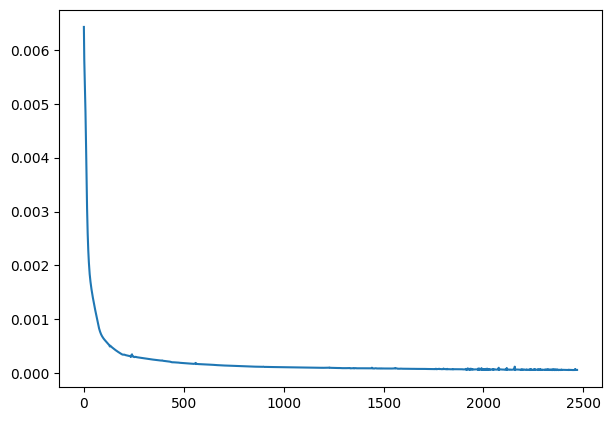

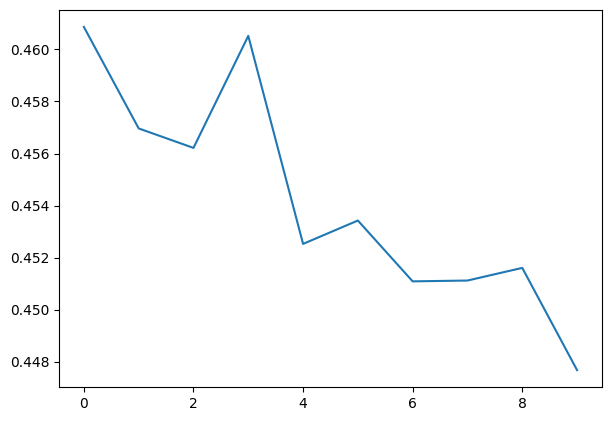

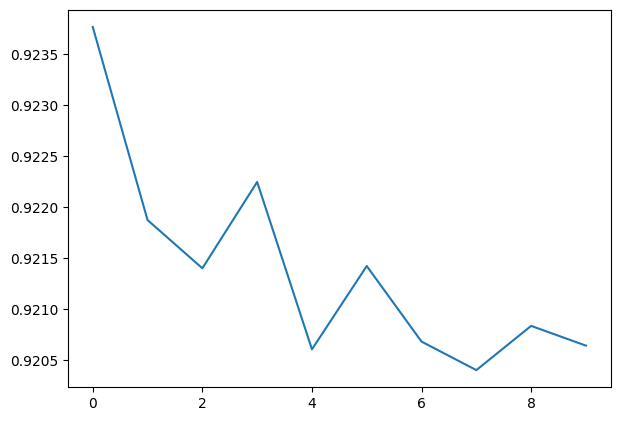

In [18]:
fig = plt.gcf()
fig.set_dpi(100)
fig.set_size_inches(7, 5, forward=True)
plt.plot(train_autoencoder_loss_history[30:])
plt.pause(0.05)
fig = plt.gcf()
fig.set_dpi(100)
fig.set_size_inches(7, 5, forward=True)
plt.plot(a_r_s_scores_history_auto[0:])
plt.pause(0.05)
fig = plt.gcf()
fig.set_dpi(100)
fig.set_size_inches(7, 5, forward=True)
plt.plot(h_s_scores_history_auto[0:])

### Train CBoS

In [19]:

n_epochs = 2500

without_encoder = False
cbos.train()
# csos.train()

for epoch in tqdm(range(1, n_epochs+1)):
    train_cbos_loss = 0.0
    train_auto_loss = 0.0

    ###################
    # train the model #
    ###################
    cbos_optimizer.zero_grad()
    
    for data in bok_data_loader:
        context, target = data
        context = context.to(device)
        target = target.to(device)
        
        batch_size = target.size(0)

        target_pred = cbos(context)
        cbos_loss = criterionL1(target_pred, target)
        cbos_loss.backward()
        
        cbos_optimizer.step()
        cbos_optimizer.zero_grad()

        
        train_cbos_loss += cbos_loss.item()*batch_size
            
    # print avg training statistics 
    train_cbos_loss = train_cbos_loss/len(bok_data_loader)   
    train_cbos_loss_history.append(train_cbos_loss)

    if epoch % 250 == 0:
        print(f'Epoch: {epoch} \tTraining Cbos Loss: {train_cbos_loss:.6f}, train_auto_loss_history: {0}')
        X, lbls, _ = get_data_from_encoder(encoder)
        a_r_s, h_s = cluster_data_mean(X, n_components=50, mode='KM', retries_num=30, lbls=lbls)

        a_r_s_scores_history.append(a_r_s)
        h_s_scores_history.append(h_s)
    
        print('adjusted_rand_score:\t', a_r_s)
        print('homogeneity_score:\t', h_s, flush=True)

 10%|▉         | 249/2500 [00:38<05:25,  6.91it/s]

Epoch: 250 	Training Cbos Loss: 1.206362, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.44212691401097504
homogeneity_score:	 0.8981520627135494


 20%|█▉        | 499/2500 [01:27<04:49,  6.92it/s]  

Epoch: 500 	Training Cbos Loss: 1.198628, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.50400078503875
homogeneity_score:	 0.906634841450665


 30%|██▉       | 749/2500 [02:16<04:23,  6.64it/s]  

Epoch: 750 	Training Cbos Loss: 1.192209, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.505227986413788
homogeneity_score:	 0.9101721793601535


 40%|███▉      | 999/2500 [03:07<03:57,  6.31it/s]  

Epoch: 1000 	Training Cbos Loss: 1.187058, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.5026220584151818
homogeneity_score:	 0.9163565310438299


 50%|████▉     | 1249/2500 [03:57<03:18,  6.30it/s]  

Epoch: 1250 	Training Cbos Loss: 1.173216, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.48937806435139397
homogeneity_score:	 0.9230166142220715


 60%|█████▉    | 1499/2500 [04:48<02:38,  6.32it/s]  

Epoch: 1500 	Training Cbos Loss: 1.160235, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.4891677440013816
homogeneity_score:	 0.9247426890017435


 70%|██████▉   | 1749/2500 [05:40<01:58,  6.31it/s]

Epoch: 1750 	Training Cbos Loss: 1.147564, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.48566936419153417
homogeneity_score:	 0.9230216785573465


 80%|███████▉  | 1999/2500 [06:32<01:19,  6.27it/s]

Epoch: 2000 	Training Cbos Loss: 1.132698, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.4864920415713142
homogeneity_score:	 0.9232313132633425


 90%|████████▉ | 2249/2500 [07:26<00:41,  6.00it/s]

Epoch: 2250 	Training Cbos Loss: 1.121355, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.48724085416734547
homogeneity_score:	 0.9229602009396245


100%|█████████▉| 2499/2500 [08:22<00:00,  6.31it/s]

Epoch: 2500 	Training Cbos Loss: 1.111470, train_auto_loss_history: 0
100.00%
adjusted_rand_score:	 0.48452780245502436
homogeneity_score:	 0.9205095415017873


100%|██████████| 2500/2500 [08:32<00:00,  4.88it/s]


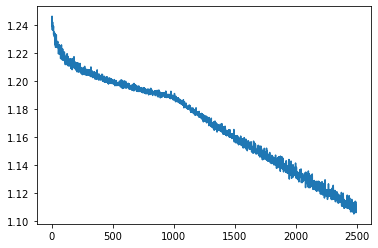

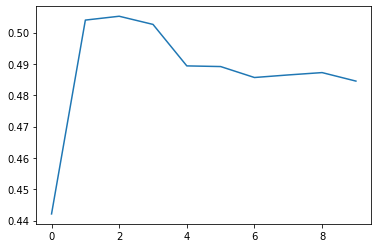

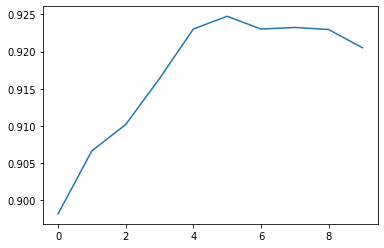

In [38]:
plt.plot(train_cbos_loss_history[3:])
plt.pause(0.05)
plt.plot(a_r_s_scores_history[0:])
plt.pause(0.05)
plt.plot(h_s_scores_history[0:])

### Cluster Data

In [21]:
X_unmodified, lbls_un, true_lbls_un = dataset.get_full_data()
X_CboS, lbls_cbos, true_lbls_cbos  = get_data_from_encoder(encoder)

Without CBos (unmodified)

In [22]:
pred_un = cluster_data(X_unmodified, n_components=50, mode='KM', retries_num=30, lbls=lbls_un)

print('adjusted_rand_score:\t', adjusted_rand_score(lbls_un, pred_un))
print('homogeneity_score:\t', homogeneity_score(lbls_un, pred_un))
print('calinski_harabasz_score:\t', calinski_harabasz_score(X_unmodified, pred_un))
print('silhouette_score:\t', silhouette_score(X_unmodified, pred_un))

100.00%
adjusted_rand_score:	 0.48094335935742266
homogeneity_score:	 0.9308701815944631
calinski_harabasz_score:	 46825.590352218256
silhouette_score:	 0.56286156


In [23]:
a_r_s, h_s = cluster_data_mean(X_unmodified, n_components=50, mode='KM', retries_num=30, lbls=lbls_un)
print('Mean adjusted_rand_score:\t', a_r_s)
print('Mean homogeneity_score:\t', h_s)

100.00%
Mean adjusted_rand_score:	 0.45280473482450206
Mean homogeneity_score:	 0.9242436778963496


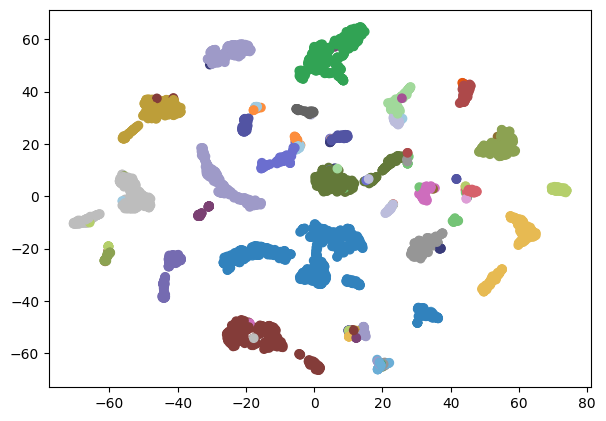

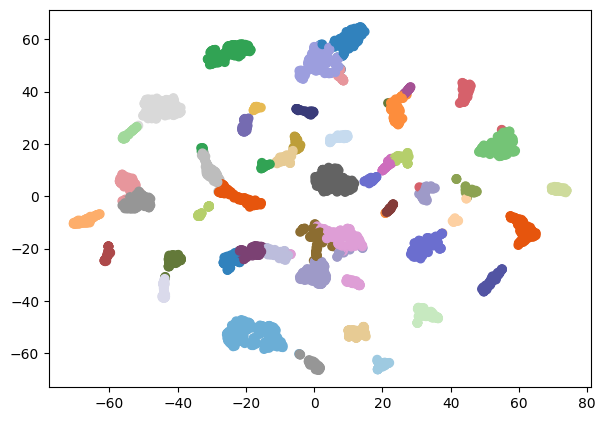

In [24]:
show_cluster_compare(X_unmodified, lbls_un, pred_un)

With CBos

In [25]:
pred_cbos = cluster_data(X_CboS, n_components=50, mode='KM', retries_num=30, lbls=lbls_cbos)

print('adjusted_rand_score:\t', adjusted_rand_score(lbls_cbos, pred_cbos))
print('homogeneity_score:\t', homogeneity_score(lbls_cbos, pred_cbos))
print('calinski_harabasz_score:\t', calinski_harabasz_score(X_CboS, pred_cbos))
print('silhouette_score:\t', silhouette_score(X_CboS, pred_cbos))

100.00%
adjusted_rand_score:	 0.5058884587910978
homogeneity_score:	 0.9286734776546401
calinski_harabasz_score:	 11979.527153960475
silhouette_score:	 0.55517524


In [26]:
a_r_s, h_s = cluster_data_mean(X_CboS, n_components=50, mode='KM', retries_num=30, lbls=lbls_cbos)
print('Mean adjusted_rand_score:\t', a_r_s)
print('Mean homogeneity_score:\t', h_s)

100.00%
Mean adjusted_rand_score:	 0.4867412277200602
Mean homogeneity_score:	 0.9211046695231688


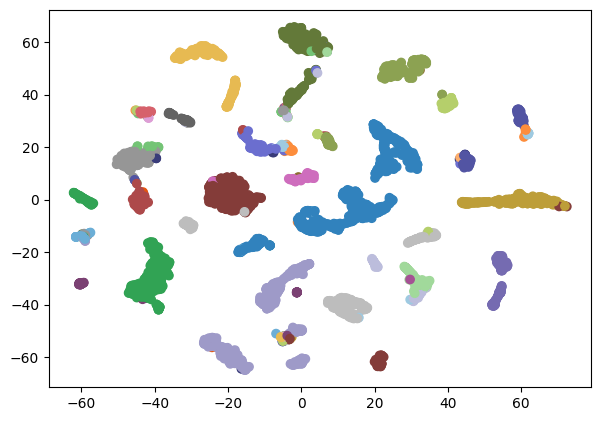

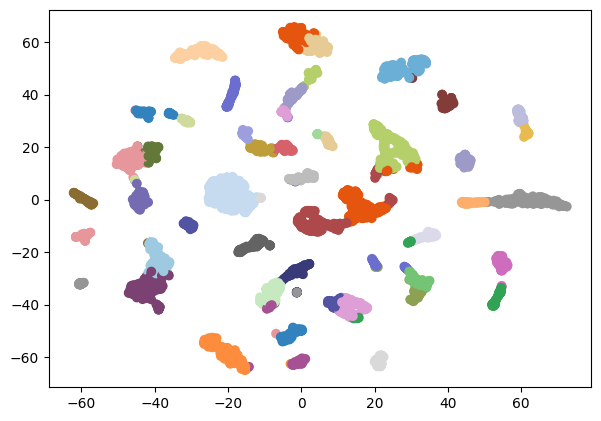

In [27]:
show_cluster_compare(X_CboS, lbls_cbos, pred_cbos)

In [28]:
X = X_unmodified
lbls = lbls_un
true_lbls = true_lbls_un

In [29]:
X = X_CboS
lbls = lbls_cbos
true_lbls = true_lbls_cbos

### HMM Train

In [30]:
space_pred = cluster_data(X_unmodified, n_components=2, mode='KM', retries_num=10)
def build_emission_prob(pred, n_clusters, space_pred=space_pred):
    if np.count_nonzero((space_pred == 0)) < len(space_pred) / 2:
        space_lbl = 0
    else:
        space_lbl = 1

    test = {}
    for p, s in zip(pred, space_pred):
        if p not in test:
            test[p] = [0, 0]
        test[p][0] += 1
        if s == space_lbl:
            test[p][1] += 1

    space_for_em_m = [0.0 for _ in range(n_clusters)]
    max_spaces = 0
    for i in test.items():
        space_for_em_m[i[0]] = i[1][1]
        if i[1][1] > max_spaces:
            max_spaces = i[1][1]
    space_for_em_m
    emissionprob = np.ones((len(keys), n_clusters), dtype=np.float64)
    id_m = id_map(keys)
    for i, line in enumerate(emissionprob):
        line = np.random.uniform(9, 10, n_clusters)
        for j in range(n_clusters):
            if i == id_m[' ']:
                line[j] += space_for_em_m[j]* 2
            else:
                    line[j] *= 1 - space_for_em_m[j] / (max_spaces + 1)
        emissionprob[i] = line / np.sum(line)


    return emissionprob

100.00%


In [31]:
best_model = None
max_score = -100000000
retries_num = 10

k = 55
a_r_s = 0
h_s = 0
accuracy = []
print(f'CLUSTERS_N: {k}')
for try_i in range(retries_num):
    pred = cluster_data(X, n_components=k, mode='KM', retries_num=1)
    a_r_s += adjusted_rand_score(lbls, pred)
    h_s += homogeneity_score(lbls, pred)

    pred_hhm = pred_for_hmm(pred) 


    model = hmm.MultinomialHMM(n_components=30, init_params='s', params='se', n_iter=1000)
    model.transmat_ = trans_mat
    model.emissionprob_ = build_emission_prob(pred, k)

    model.fit(pred_hhm)

    score = dataset.score(decode_pred(model.predict(pred_hhm), keys) )

    matched_str = words_in_wordlist(decode_pred(model.predict(pred_hhm), keys), word_list_dataset, min_length=4)
    print('Current Dataset Accuracy:', score)
    print('Chars from words len:', len(matched_str))

    accuracy.append(score)

    if len(matched_str) > max_score:
        best_model = model
        max_score = len(matched_str)
        pred_text_encoded = model.predict(pred_hhm)
        best_multi_score = score
    if try_i % 5 == 0:
        print(f"Best accuracy at {try_i}:\t{best_multi_score}")

accuracy.sort()
print()
print('adjusted_rand_score:\t', a_r_s/retries_num)
print('homogeneity_score:\t', h_s/retries_num)
print('Median accuracy:\t', accuracy[retries_num//2])
print('Mean accuracy:\t', sum(accuracy)/retries_num)
print('Max accuracy:\t', accuracy[retries_num-1])


CLUSTERS_N: 55
100.00%
Current Dataset Accuracy: 0.8838465694219341
Chars from words len: 1051
Best accuracy at 0:	0.8838465694219341
100.00%
Current Dataset Accuracy: 0.8830361966504592
Chars from words len: 999
100.00%
Current Dataset Accuracy: 0.8757428417071853
Chars from words len: 1019
100.00%
Current Dataset Accuracy: 0.8876283090221502
Chars from words len: 1153
100.00%
Current Dataset Accuracy: 0.8892490545651
Chars from words len: 1139
100.00%
Current Dataset Accuracy: 0.882766072393301
Chars from words len: 1080
Best accuracy at 5:	0.8876283090221502
100.00%
Current Dataset Accuracy: 0.8897893030794165
Chars from words len: 1132
100.00%
Current Dataset Accuracy: 0.8797947055645597
Chars from words len: 1045
100.00%
Current Dataset Accuracy: 0.8833063209076175
Chars from words len: 1131
100.00%
Current Dataset Accuracy: 0.8895191788222583
Chars from words len: 1192

adjusted_rand_score:	 0.4525450095737161
homogeneity_score:	 0.9263054156713517
Median accuracy:	 0.88384656942

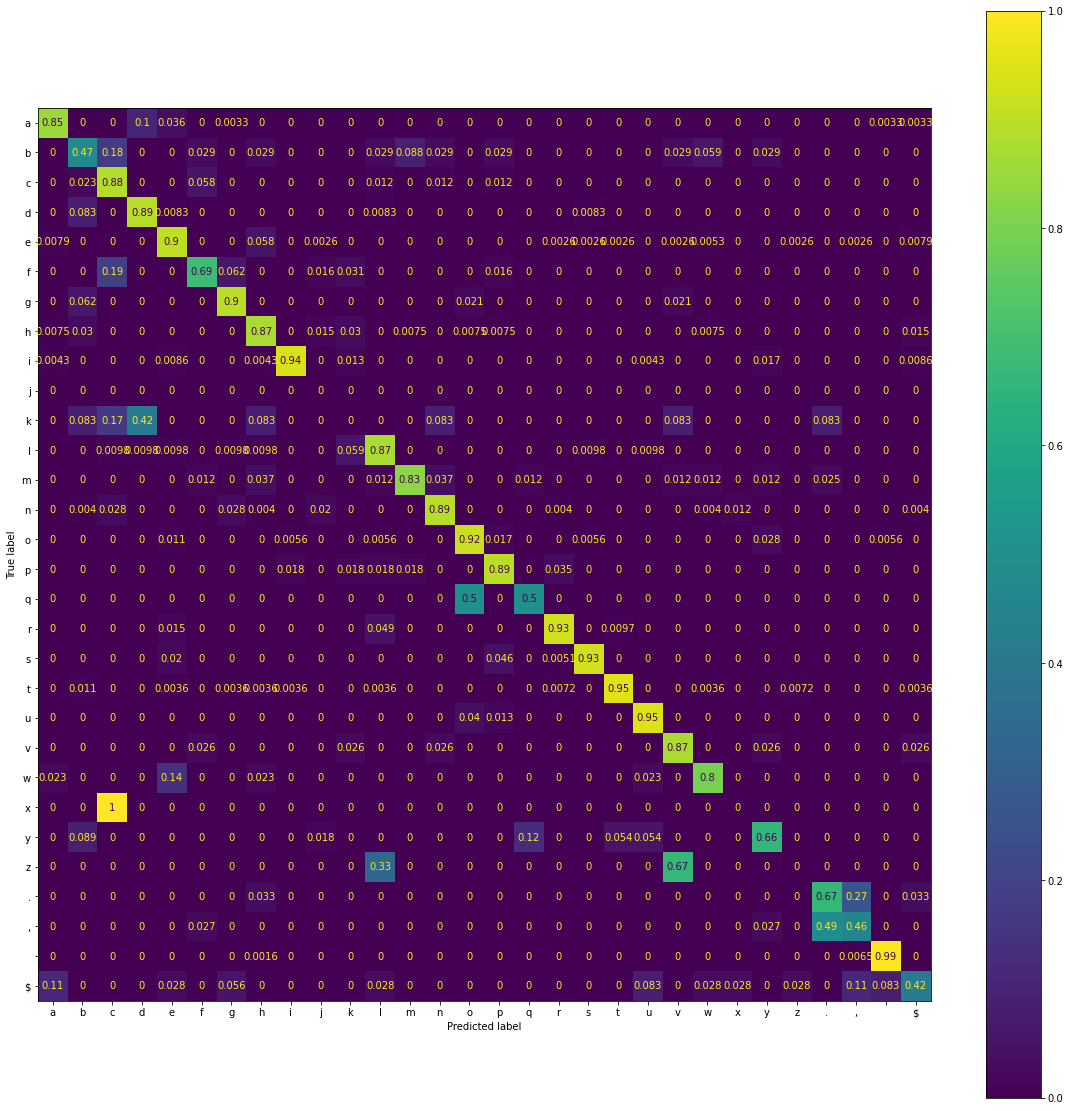

In [32]:
show_keys_confusion_matrix(pred_text_encoded, true_lbls, keys)

### HMM + Language Results 

HMM Result

In [33]:
pred_text_hmm = decode_pred(pred_text_encoded, keys)
print('HMM Character Precision:', dataset.score(pred_text_hmm))
print('HMM Word Precision:', word_precision(dataset.original_text[:], pred_text_hmm))
pprint_pred(dataset.original_text[:], pred_text_hmm)

HMM Character Precision: 0.8895191788222583
HMM Word Precision: 0.6151368760064412
xtha is an aromatic beverage prerared by pooreng hot or pouling water ofer cored or fresh leaves of camellia singensis, an evergreen sprof wative to ckind. indid and other wast asian countries, tha is also realy made frof the leaves of camellia talientsis$$$$$$z afrer wathe, it is the most wiedly bensmed brind on the planeth there are many diccerent types of the. sove have a cooling. plightly wither. and astrinvent, flavor, while others have vasely different prof$kes that include sevet, jutty, ckeras, or grassy, $otes, ted has a stimugating eckect in jumans primally bue to its cackeine fintent. ted puants are catike to hast asid and promally originated in the borderland of southeestern china and corthern burma. an hally fredicke record of ted drinding bates to the third century ad. in a medical tect written juby jud tus, it was popplalised as a recreational blind suring the chinese tang sthasty. and ted 

Bigram correction results

In [34]:
pred_bigram = bigramPredictor.Viterbi(pred_text_hmm, max_corr_a=0.3, E=E)
print('Bigram Character Precision:', dataset.score(pred_text_hmm))
print('Bigram Word Precision:', word_precision(dataset.original_text[:], pred_text_hmm))
pprint_pred(dataset.original_text[:], pred_text_hmm)

Bigram Character Precision: 0.8895191788222583
Bigram Word Precision: 0.6151368760064412
xtha is an aromatic beverage prerared by pooreng hot or pouling water ofer cored or fresh leaves of camellia singensis, an evergreen sprof wative to ckind. indid and other wast asian countries, tha is also realy made frof the leaves of camellia talientsis$$$$$$z afrer wathe, it is the most wiedly bensmed brind on the planeth there are many diccerent types of the. sove have a cooling. plightly wither. and astrinvent, flavor, while others have vasely different prof$kes that include sevet, jutty, ckeras, or grassy, $otes, ted has a stimugating eckect in jumans primally bue to its cackeine fintent. ted puants are catike to hast asid and promally originated in the borderland of southeestern china and corthern burma. an hally fredicke record of ted drinding bates to the third century ad. in a medical tect written juby jud tus, it was popplalised as a recreational blind suring the chinese tang sthasty. an

### Clear Data for Classifier

In [35]:
score, matched_str, matched_indexes = format_spell_check(pred_text_hmm, dataset.original_text,  word_list_dataset, min_length=4)
print('\n', score)
print()
score, matched_str, matched_indexes = format_spell_check(pred_bigram, dataset.original_text,  word_list_dataset, min_length=1)
print('\n', score)

xtha is an aromatic beverage prerared by pooreng hot or pouling water ofer cored or fresh leaves of camellia singensis, an evergreen sprof wative to ckind. indid and other wast asian countries, tha is also realy made frof the leaves of camellia talientsis$$$$$$z afrer wathe, it is the most wiedly bensmed brind on the planeth there are many diccerent types of the. sove have a cooling. plightly wither. and astrinvent, flavor, while others have vasely different prof$kes that include sevet, jutty, ckeras, or grassy, $otes, ted has a stimugating eckect in jumans primally bue to its cackeine fintent. ted puants are catike to hast asid and promally originated in the borderland of southeestern china and corthern burma. an hally fredicke record of ted drinding bates to the third century ad. in a medical tect written juby jud tus, it was popplalised as a recreational blind suring the chinese tang sthasty. and ted blinding subshouengly spread to hast asian countries. pprtuguese priests and mercan

## Random key prediction

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def build_classifier(X, matched_indexes, matched_str):
    X_cleared, true_lbls_cleared  = clear_data(X, matched_indexes, matched_str)

    id_m = id_map(keys)
    lbls_cleared = []
    for i in true_lbls_cleared:
        lbls_cleared.append(id_m[i])
        
    # clf = LinearDiscriminantAnalysis()
    # clf = LogisticRegression(max_iter=3000, penalty='l2', C=1000000)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_depth=None, criterion='gini')

    clf.fit(X_cleared, lbls_cleared)

    pred_cleared = clf.predict(X)
    
    r_id_m = reverse_id_map(keys)
    pred_text = ''
    for i in pred_cleared:
        pred_text += r_id_m[i]
    print('Precision:', dataset.score(pred_text))
    return pred_text

In [41]:
classifier_cycles  = 10
for i in range(classifier_cycles):
    pred_text = build_classifier(X, matched_indexes, matched_str)
    pred_bigram = bigramPredictor.Viterbi(pred_text, max_corr_a=0.3)
    score, matched_str, matched_indexes = format_spell_check(pred_bigram, dataset.original_text,  word_list_dataset, min_length=4, verbose=False)


Precision: 0.9475958941112912
Precision: 0.9624527282549973
Precision: 0.9627228525121556
Precision: 0.9643435980551054
Precision: 0.9632631010264722
Precision: 0.9643435980551054
Precision: 0.9643435980551054
Precision: 0.9643435980551054
Precision: 0.9646137223122636
Precision: 0.9640734737979471


In [42]:
print('Classification Character Precision:', dataset.score(pred_text))
print('Word Precision:', word_precision(dataset.original_text[:], pred_text))
pprint_pred(dataset.original_text[:], pred_text)

Classification Character Precision: 0.9640734737979471
Word Precision: 0.8727858293075684
ntea is an aromatic beverage prepared by pooring hot or boiling water over cored or fresh leaves of camellia sin$ensis, an evergreen shroh native to china. india and other east asian comntries, tea is also realy made from the leaves oc camellia talientsis$$$$$$$ after eaten, it is the most wiedly clnsmed dring on the pl$net  there are many different types of tea. some have a cooling. slightly bitter. and astringent  flavor, while others have vastly different prof$les that include sweet, nutty, fllral, or grassy  $otes, tea has a stimulating effect in humans primarlu due to its caffeine cintent. tea plants are native to last asia and probably originated in the borderland of southeestern china and northern burma. an early credible record of tea dringing dates to the third century ad. in a medical tect written nyby hua tuo, it was popmlarised as a recreational drink suring the chinese tang dtnasty. a

### Experiments with Levenshtein distance
It's working extremely slow and pretty bad. But it has some potential. Further investigation is required  

In [43]:
(len(dataset.original_text) - distance(dataset.original_text,pred_text)) / len(dataset.original_text)

0.9640734737979471

In [44]:
print(word_list_dataset.top_n('poorwng', 10, E=get_unified_cond_prob_matrix(0.5)))
print(word_list_dataset.top_n_leven('poorwng', 10))
distance('poorwng','pouring')

(['pouring', 'mooring', 'pooling', 'pooping', 'poohing', 'looking', 'posting', 'proving', 'storing', 'booking'], [1.2499999441206461e-05, 1.2499999441206461e-05, 1.2499999441206461e-05, 1.2499999441206461e-05, 1.2499999441206461e-05, 4.99999966472388e-07, 4.99999966472388e-07, 4.99999966472388e-07, 4.99999966472388e-07, 4.99999966472388e-07])
(['pouring', 'mooring', 'pooling', 'pooping', 'poring', 'poohing', 'spooring', 'looking', 'posting', 'proving'], [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.25, 0.25, 0.25])


2

In [45]:
pred_bigram_leven = bigramPredictor.Viterbi_leven(pred_text)

In [46]:
print((len(dataset.original_text) - distance(dataset.original_text,pred_bigram_leven)) / len(dataset.original_text))
pred_bigram_leven

0.8784440842787682


'enter in a dramatic beverage prepared by looking not of boiling water over core of free leave of camelot sin$basis, and everyone shoot nation to china. india and other east asian countries, sea in all ready made from the leaves of camelot taliesins$$$$$$$ after eaten, it is the most widely claimed drink of the l$not  there are many different types of sea. some have a pooling. slightly better. and astringent  later, while others have vastly different prof$let that includes sweet, nutty, floral, of grass  $notes, sea as a stimulating effect on human primarily due to its caffeine content. tea plants are alive to last asia and probably originated in the borderland of southerners china and another burst. and early credible record of ten bringing rates to the third century and. in a medical text written baby hum to, it was population as a recreational drink during the chinese tang honesty. and ten drinking subsequently speak to last asian countries. portuguese priests and mercy$to introduce

In [47]:
pred_bsc_leven = basic_spell_check_leven(pred_text, word_list_dataset)

In [48]:
print((len(dataset.original_text) - distance(dataset.original_text,pred_bsc_leven)) / len(dataset.original_text))
pred_bsc_leven

0.9349000540248514


'tea is an aromatic beverage prepared by pouring hot or boiling water over cored or fresh leaves of camellia sin$basis, an evergreen shoot native to china. india and other east asian countries, tea is also ready made from the leaves of camellia taliesins$$$$$$$ after eaten, it is the most wildly claimed bring on the pi$net  there are many different types of tea. some have a cooling. slightly bitter. and astringent  floor, while others have vastly different prof$les that include sweet, nutty, floral, or grassy  $notes, tea has a stimulating effect in humans primary due to its caffeine content. tea plants are native to last asia and probably originated in the borderland of southeastern china and northern burma. an early credible record of tea bringing dates to the third century ad. in a medical test written baby ha to, it was popularity as a recreational drink during the chinese tang dynasty. and tea drinking subsequently spread to last asian countries. portuguese priests and merman$ts i